# Материалы

[Презентация](https://disk.yandex.ru/i/d5ex3iL7rdEHdw)

[Дашборд](https://public.tableau.com/views/da24_practikum_final_dash/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

Задание к дашборду: 
1. Постройте диаграмму, отображающую распределение заработной платы клиентов.
2. Добавьте индикатор, отображающий процент клиентов, имеющих кредитную карту.
3. Добавьте фильтр дашборда, позволяющий выбрать, ушёл клиент или нет.

# Описание проекта

Проект посвящен сегментированию пользователей банка. Сегментация покажет, как клиенты пользуются услугами банка "Метанпромбанк".

Заказчик - менеджер продукта, который разрабатывает меры по удержанию клиентов и мероприятия для работы с целевой аудиторией.
Пользователем результата по проекту будет менеджер продукта.
Цель - определить, на какие основные сегменты делятся клиенты банка и выявить характеристики каждого сегмента.

# Задачи

- Провести исследовательский анализ данных
- Сегментировать пользователей на основе данных о количестве потребляемых продуктов
- Сформулировать и проверить статистические гипотезы:

    - гипотеза различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним. 
    - гипотеза относительно представленных данных.
- подготовить презентацию

# Описание данных

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.


## Шаг 1. Загрузка данных

In [1]:
#импортируем бибилиотеки
import pandas as pd
import seaborn as sns
from datetime import date

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.cluster.hierarchy import dendrogram, linkage 
import numpy as np
from IPython.display import display

from scipy import stats as st
import numpy as np
import math as mth
import plotly.express as px

from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')

Прочитаем файл с помощью функции read_csv() с разделителем колонок sep=','. Выведем первые строки таблицы методом head(), чтобы познакомиться с данными.

In [2]:
bank_data = pd.read_csv('/datasets/bank_dataset.csv', sep=',')
display(bank_data.head())
bank_data.info()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


В датасете 12 колонок с записями о пользователях: 'userid' типа int64, 'score' типа int64, 'City' типа object, 'Gender' типа object, 'Age' типа int64, 'Objects' типа int64, 'Balance' типа float64, 'Products' типа int64, 'CreditCard' типа int64, 'Loyalty' типа int64, 'estimated_salary' типа float64 и Churn типа int64. 

Всего в датасете 10000 строк в каждом столбце, кроме столбца Balance. Значит, пропуски есть только в нем. 

Все типы данных корректны.

## Шаг 2.  EDA

Исследовательский анализ данных:
   - определение и изучение пропущенных значений
   - приведение данных к нужным типам
   - обнаружение и отсечение редких и выбивающихся значений при необходимости
   - изучение распределения и зависимостей признаков 

### Определение и изучение пропущенных значений

В названиях столбцов изменим регистр на нижний, чтобы избежать путаницы.


In [3]:
#приведем название столбцов к нижнему регистру для удобства
bank_data.columns = bank_data.columns.str.lower()

In [4]:
#посмотрим процент нулевых значений
pd.DataFrame(round((bank_data.isna().mean()*100),2)).style.background_gradient()

,0
userid,0
score,0
city,0
gender,0
age,0
objects,0
balance,36.17
products,0
creditcard,0
loyalty,0


36% значений в столбце Balance - нулевые. 
Баланс может быть нулевым, так как не все продукты предполагают наличие дебетового счета.
Если он отсутствует, можно считать его нулевым и заполнить нулями.

Введем новый столбец, где сохраним флаг отсутствия баланса, и выведем средние значения параметров в разрезе этого флага.

In [5]:
bank_data['balance_na'] = 1
bank_data.loc[bank_data['balance'] >= 0, 'balance_na'] = 0

bank_data.groupby('balance_na').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
balance_na,,,,,,,,,,
0,1.573310e+07,651.138493,39.197713,4.979633,119827.493793,1.386025,0.699201,0.513552,100717.352956,0.240796
1,1.573469e+07,649.452861,38.434891,5.071330,NaN,1.784628,0.716616,0.517832,98983.559549,0.138236


Замечаем разницу средних значений только у двух параметров - у клиентов с отсутствующим балансом в среднем больше продуктов и меньший процент оттока.

In [6]:
#заменим отсутствующий баланс на нули
bank_data['balance'] = bank_data['balance'].fillna(0.0)
bank_data.isnull().sum()

userid              0
score               0
city                0
gender              0
age                 0
objects             0
balance             0
products            0
creditcard          0
loyalty             0
estimated_salary    0
churn               0
balance_na          0
dtype: int64

Пробежимся по данным и проверим их на корректность. Для этого воспользуемся методом describe() для численных строк и методами .unique()/.value_counts() для категориальных данных.

In [7]:
bank_data['userid'].value_counts()

15683582    1
15689038    1
15670617    1
15619416    1
15787350    1
           ..
15844029    1
15858362    1
15641272    1
15733431    1
15634434    1
Name: userid, Length: 10000, dtype: int64

Всего в датасете 10000 уникальных идетификаторов пользователя.

In [8]:
bank_data['score'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: score, dtype: float64

Максимальный балл кредитного скоринга составляет 850 единиц, минимальный - 350. Медиана и среднее примерно равны - 652 и 650 соответственно, так что можем предположить, что данные распределены нормально. Стандартное отклонение - 96, коэффициент вариации равен отношению стандартного отклонения к среднему значению, это 14%, поэтому можно сказать, что выборка вариабельна средне.

In [9]:
bank_data['age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

In [10]:
bank_data['city'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

В датасете предствалены данные о клиентах трех городов - Ярославль (50% клиентов), Ростов Великий (25% клиентов) и Рыбинск (25%клиентов).

In [11]:
bank_data['gender'].value_counts()

М    5457
Ж    4543
Name: gender, dtype: int64

По полу данные распределены почти поровну - 55% мужчин и 45% женщин.

In [12]:
bank_data['objects'].describe()

count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: objects, dtype: float64

Максимальное число объектов у клиентов в собственности - 10, минимальное - 0. Среднее и медиана - 5 объектов. Выбросов, скорее всего, здесь нет. Коэффициент вариации равен 58%, поэтому можно сказать, что выборка сильно вариабельна.


In [13]:
bank_data['products'].describe()

count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: products, dtype: float64

Количество продуктов, которыми пользуется клиент, составляет в среднем 1. Медиана равна 1, среднее - 1,5.
Минимальное число продуктов - 1, максимальное - 4 продукта.
Коэффициент вариации равен 38%, поэтому можно сказать, что выборка сильно вариабельна.

In [14]:
bank_data['creditcard'].value_counts()

1    7055
0    2945
Name: creditcard, dtype: int64

In [15]:
bank_data['creditcard'].describe()

count    10000.00000
mean         0.70550
std          0.45584
min          0.00000
25%          0.00000
50%          1.00000
75%          1.00000
max          1.00000
Name: creditcard, dtype: float64

У 70% клиентов есть кредитная карта банка. 

In [16]:
bank_data['loyalty'].value_counts()

1    5151
0    4849
Name: loyalty, dtype: int64

In [17]:
bank_data['loyalty'].describe()

count    10000.000000
mean         0.515100
std          0.499797
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: loyalty, dtype: float64

Примерно 50% клиентов из выборки являются активными клиентами банка.

In [18]:
bank_data['estimated_salary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64

Предполагаемая средняя заработная плата клиента составляет  100 тысяч рублей, медиана примерно на том же уровне (100193), скорее всего, выбросов нет, распределение нормальное. Максимальная зарплата - 199992 рублей, минимальная - 11. Возможно, клиент ошибся при заполнении какой-либо анкеты с информацией о зарплате или система рассчитала такой параметр автоматически.

In [19]:
bank_data['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

In [20]:
bank_data['churn'].describe()

count    10000.000000
mean         0.203700
std          0.402769
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: churn, dtype: float64

Почти 20% из клиентов - это те, кто ушли, 80% остались клиентами банка.

In [21]:
#посмотрим на все данные в одной таблице. Воспользуемся методом describe, дополнив его модой
describe = bank_data.describe()
mode = bank_data.mode(axis=0).dropna().rename({0: 'mode'}, axis='index')

mct = pd.concat([describe, mode], sort=False).T

display(mct)

,count,mean,std,min,25%,50%,75%,max,mode
userid,10000,1.57337e+07,71936.2,1.56084e+07,1.56713e+07,1.57335e+07,1.5796e+07,1.58584e+07,1.56084e+07
score,10000,650.529,96.6533,350,584,652,718,850,850
age,10000,38.9218,10.4878,18,32,37,44,92,37
objects,10000,5.0128,2.89217,0,3,5,7,10,2
balance,10000,76485.9,62397.4,0,0,97198.5,127644,250898,0
products,10000,1.5302,0.581654,1,1,1,2,4,1
creditcard,10000,0.7055,0.45584,0,0,1,1,1,1
loyalty,10000,0.5151,0.499797,0,0,1,1,1,1
estimated_salary,10000,100090,57510.5,11.58,51002.1,100194,149388,199992,24924.9
churn,10000,0.2037,0.402769,0,0,0,0,1,0


Изучим записи с минимальными зарплатами:

In [22]:
bank_data.sort_values('estimated_salary').head(10)

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_na
2362,15833789,709,Ростов Великий,М,45,4,122917.71,1,1,1,11.58,1,0
9647,15722429,625,Ярославль,М,31,5,0.00,2,0,1,90.07,0,1
9010,15829199,645,Ростов Великий,Ж,59,8,121669.93,2,0,0,91.75,1,0
5548,15682398,710,Ярославль,М,38,2,0.00,2,1,0,96.27,0,1
4989,15645587,629,Ярославль,М,40,9,0.00,1,1,0,106.67,0,1
7565,15666105,708,Ярославль,М,52,10,105355.81,1,1,0,123.07,1,0
2498,15691471,718,Ярославль,М,37,8,0.00,2,1,1,142.81,0,1
8722,15761403,621,Ярославль,М,35,7,87619.29,1,1,0,143.34,0,0
4774,15683157,811,Ярославль,Ж,35,7,0.00,1,1,1,178.19,0,1
1451,15726934,551,Ярославль,Ж,38,10,0.00,2,1,1,216.27,0,1


У клиентов с крайне низкой зарплатой баланс часто значительно больше и примерно равен среднему значению. Скорее всего, такие низкие значения вызваны нехваткой информации об этих клиентах - например, они могут не участвовать в зарплатном проекте или иметь серую зарплату.

Выведем средние значения и стандартные отклонения всех признаков в одной таблице для наглядности.


In [23]:
display(bank_data.agg(['mean','std']))

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_na
mean,1.573368e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.361700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.480517


In [24]:
#посчитаем коэффициент вариации
a = bank_data.agg(['mean','std'])
a.loc[a.index == 'std']/a.loc[a.index == 'mean'].values

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_na
std,0.004572,0.148577,0.269458,0.576958,0.815803,0.380117,0.646124,0.970291,0.574586,1.977264,1.328495


Для признаков age, objects, balance, products, creditcard, loyalty, estimated_salary, churn выборка вариабельна сильно.

Для признака score выборка вариабельна средне.

Для признака userid выборка вариабельна слабо.

Посмотрим на дубликаты.

In [25]:
bank_data[bank_data.duplicated()]

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_na


Как видим, полных дубликатов в таблице нет. Оценив первые 10 строк таблицы, мы можем сделать предположение, что поиск дубликатов по отдельным столбцам таблицы не имеет значения, так как они неизбежно будут обнаружены в силу логики хранения данных в таблице.

Столбец userid содержит идентификационные данные о пользователе, удалим его, значения в нем уникальны и не могут быть признаками в модели.

In [26]:
bank_data = bank_data.drop(columns=['userid'])

### Изучение распределения и зависимостей признаков

Создадим функцию построения гистограммы и боксплота по признакам из таблицы.
Число объектов в рассматриваемых группах отличается, поэтому вместо гистограмм частот будем строить гистограммы плотностей.

In [27]:
def hist_boxplot(data, column):
    '''
    Функция строит гистограмму и боксплот для визуализации распределения.
    ***
    На вход подается название датафрейма и столбца.
    '''
    sns.set_style("darkgrid")
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5),gridspec_kw={'width_ratios': [3, 1]})
    
    min_value = min(data[column])
    max_value = max(data[column])
    bins_range = np.linspace(min_value, max_value, 10) # список границ столбиков гистограмм

    sns.distplot(data[column], kde=False, ax=ax1, color="#69A7EB", norm_hist=True, bins = bins_range)
    ax1.set_ylabel('Частота')
    ax1.set_xlabel('Параметр {}'.format(column))
    ax1.set_title("Распределение параметра {}".format(column))
    
    sns.boxplot(y=column, data=data, ax=ax2, color="#4698EB")
    sns.stripplot(y=column, data=data, jitter=True, zorder=1, color='#72AEEB', ax=ax2, size=2, alpha=0.2)
    ax2.set_title("Boxplot для параметра {}".format(column))
    ax2.set_ylabel('Параметр {}'.format(column))
    
    plt.show()

Создадим список количественных переменных и вызовем для него функцию:



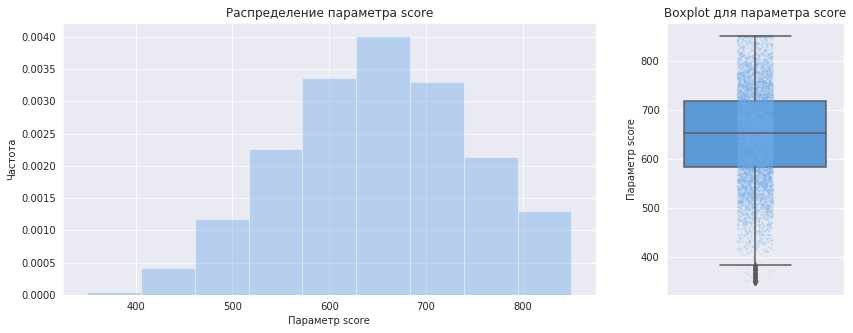

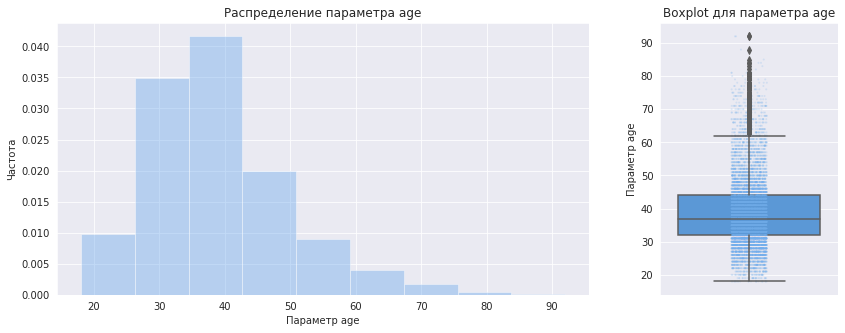

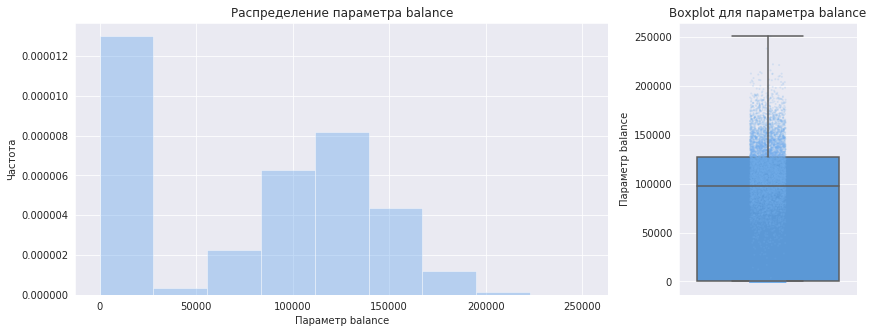

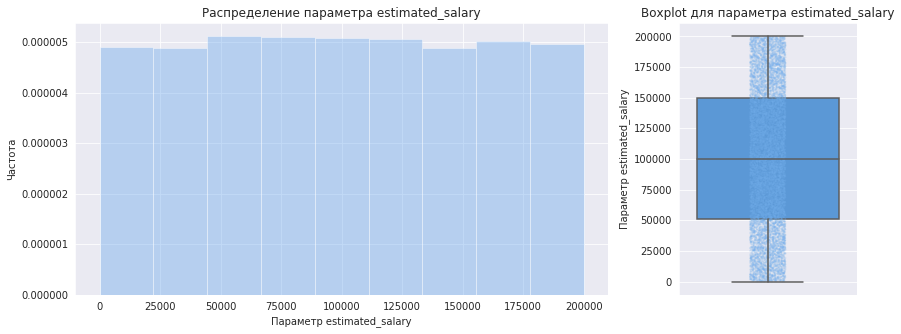

In [28]:
numeric = ['score', 'age', 'balance', 'estimated_salary']

for col in numeric:
    hist_boxplot(bank_data, col)

Видим, что баллы кредитного скоринга, возраст и баланс имеют распределение, близкое к нормальному. Распределение баланса искажают искусственно добавленные нами в ходе предобработки данных нулевые значения.

Распределение параметра зарплаты равномерное по всей выборке.


Для категориальных данных построим столбчатые диаграммы.

In [29]:
categorical = ['city', 'gender', 'creditcard', 'loyalty', 'objects', 'products']

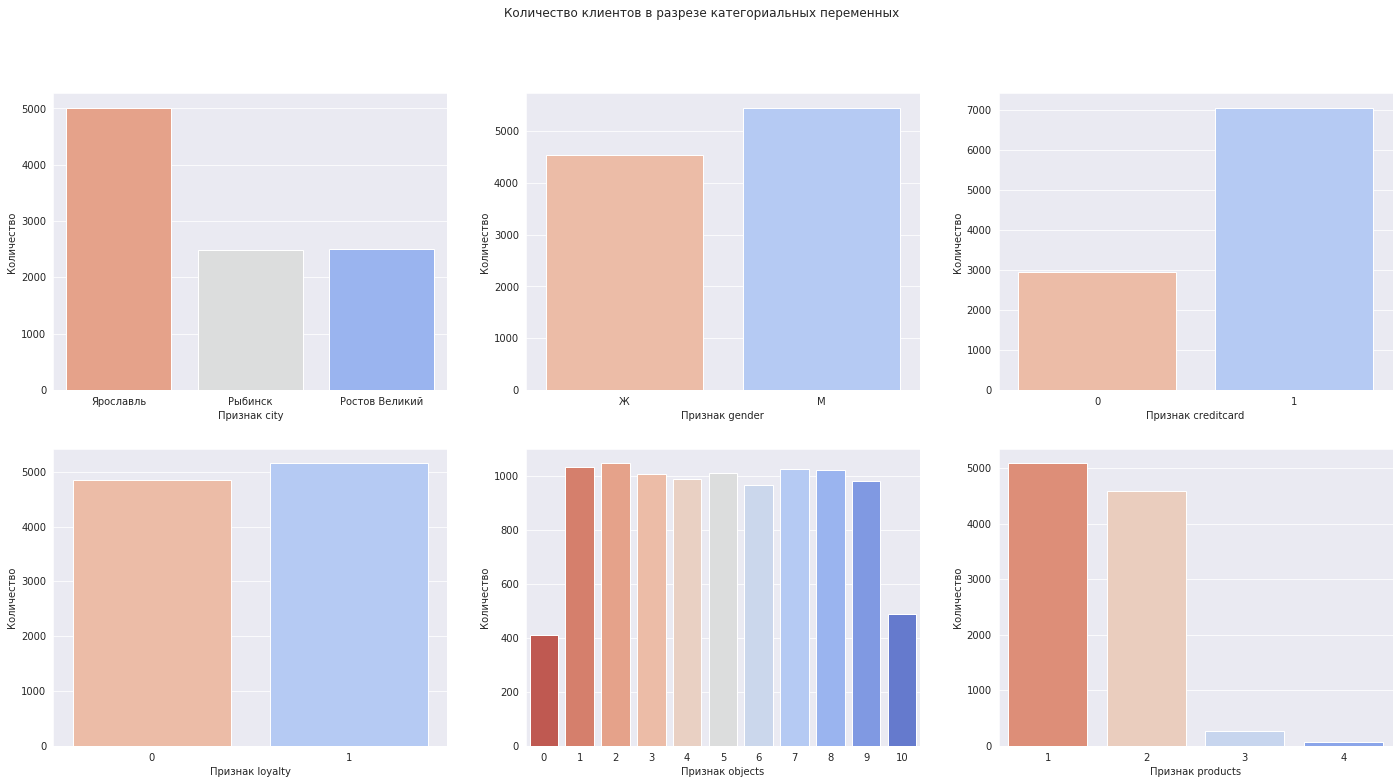

In [30]:
fig, ax = plt.subplots(2, int(len(categorical)/2), figsize=(24, 12))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(bank_data[variable], ax=subplot, palette="coolwarm_r")
    subplot.set_ylabel('Количество')
    subplot.set_xlabel('Признак {}'.format(variable))
fig.suptitle("Количество клиентов в разрезе категориальных переменных");

Из получившихся графиков можно сделать следующие выводы:

- Ярославль подтверждает статус областного центра - в нем примерно столько же клиентов, сколько в остальных городах в сумме;
- среди клиентов больше мужчин, но незначительно;
- кредитными картами пользуется большая часть клиентов (70%);
- количество активных и неактивных клиентов практически совпадает;
- количество объектов в собственности распределено равномерно, меньше всего клиентов c 0 и 10 объектами;
- подавляющее количество клиентов пользуются не более, чем 2 продуктами.

### Корреляционный анализ

Приведем категориальные переменные (city и gender) к количественным, чтобы они участвовали в корреляционном анализе. Используем преобразование one-hot encoding.

In [31]:
bank_data_corr = bank_data.copy()
bank_data_corr['city_orig'] = bank_data_corr['city']
bank_data_corr['gender_orig'] = bank_data_corr['gender']
bank_data_corr = pd.get_dummies(bank_data_corr, columns=['gender','city'])
display(bank_data_corr.head())

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_na,city_orig,gender_orig,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,619,42,2,0.00,1,1,1,101348.88,1,1,Ярославль,Ж,1,0,0,0,1
1,608,41,1,83807.86,1,0,1,112542.58,0,0,Рыбинск,Ж,1,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,Ярославль,Ж,1,0,0,0,1
3,699,39,1,0.00,2,0,0,93826.63,0,1,Ярославль,Ж,1,0,0,0,1
4,850,43,2,125510.82,1,1,1,79084.10,0,0,Рыбинск,Ж,1,0,0,1,0


Вычислим корреляционную матрицу и выведем на ее основе тепловую карту.

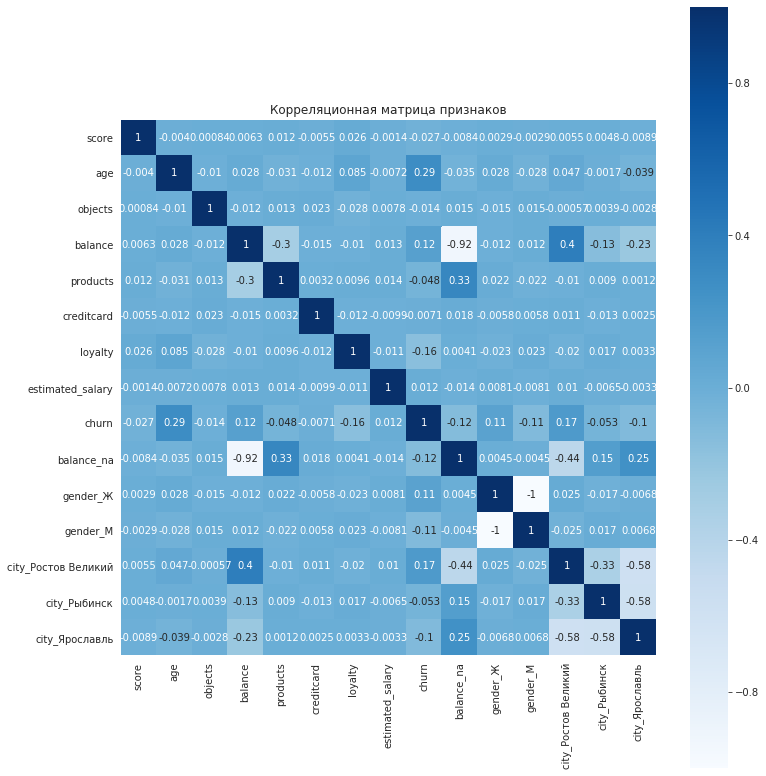

In [32]:
fig, ax = plt.subplots(figsize=(12,14))

sns.heatmap(bank_data_corr.corr(), annot = True, square=True, cmap="Blues")
ax.set_title("Корреляционная матрица признаков")
plt.show()

Замечаем, что отток наиболее сильно коррелирует с возрастом клиента (0,29), городом (особенно с Ростовом - 0,17), лояльностью (-0,16) и текущим балансом (0,12). Однако корреляция довольно слабая.

Нет корреляции между уровнем дохода и возрастом. Есть небольшая обратная корреляция (-0.3) между количеством продуктов и балансом на счету клиента.

Флаг отсутствия баланса сильнее всего коррелирует с количеством продуктов (0,33) и городом, исследуем эту особенность дополнительно, посчитав долю клиентов без баланса в разбивке по этим параметрам:

In [33]:
display(bank_data_corr.groupby('city_orig')['balance_na'].mean().reset_index())


,city_orig,balance_na
0,Ростов Великий,0.000000
1,Рыбинск,0.484053
2,Ярославль,0.482250


Видим, что отсутствие баланса свойственно только для Рыбинска и Ярославля. Возможно это все же ошибки при выгрузке данных. Например, если данные по городам выгружали разные сотрудники или разные системы.

In [34]:
display(bank_data_corr.groupby('products')['balance_na'].mean().reset_index())

,products,balance_na
0,1,0.178009
1,2,0.566449
2,3,0.368421
3,4,0.233333


Больше всего пропусков по балансу для тех клиентов, кто пользуется 2 продуктами банка (56%).

### Изучение признаков в разрезе оттока

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [35]:
display(bank_data.groupby('churn')['creditcard'].agg('count'))

churn
0    7963
1    2037
Name: creditcard, dtype: int64

Отток составил 2037 человек, осталось 7963 человек.

In [36]:
#оценим медианные значения
display(bank_data_corr.groupby('churn').agg('median'))

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,balance_na,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
churn,,,,,,,,,,,,,,
0,653,36,5,92072.68,2,1,1,99645.04,0,0,1,0,0,1
1,646,45,5,109349.29,1,1,0,102460.84,0,1,0,0,0,0


In [37]:
#оценим средние значения
display(bank_data_corr.groupby('churn').agg('mean'))

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,balance_na,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
churn,,,,,,,,,,,,,,
0,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,99738.391772,0.391435,0.427477,0.572523,0.212859,0.259199,0.527942
1,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531,0.245459,0.559156,0.440844,0.399607,0.202749,0.397644


- Распределение по баллам кредитного скоринга примерно равное как для тех кто ушел, так и для тех, кто остался, - 645-650 баллов в среднем.
- Средний возраст клиентов, попавших в отток, выше (45 лет), чем возраст тех, кто остался (37 лет).
- Среднее количество объектов в собственности у обоих групп - 5.
- Среди тех, кто ушел, большинство - это женщины (55%), а среди тех, кто остался - это мужчины (57%).
- Средний баланс на счёте у тех, кто не попал в отток, - 72745. Средний баланс на счёте у тех, кто попал в отток - 91108.
- Количество продуктов, которыми пользуются клиенты из оттока и не из оттока, примерно равно 1.5, будем считать, что это 1 продукт.
- Из числа тех, что попал и не попал в отток, около 70% - владельцы кредитных карт. 
- Большинство оставшихся - это клиенты из Ярославля (53%), далее идет Рыбинск (26%) и Ростов (21%). Из тех клиентов, кто ушел, это по 40% из Ростова и Ярославля и 20% из Рыбинска.
- Среди тех, кто попал в отток, только 36% были активными клиентами; а среди тех, кто остался, 55% - это активные клиенты.
- Средняя заработная плата ушедших клиентов (101465) выше, чем средняя зартлата тех, кто остались клиентами банка (99738).

Резюмируя, сильнее всего в зависимости от факта оттока отличаются возраст, баланс, активность и город. Также в группе с ушедшими клиентами выше доля женщин, несмотря на то, что их в целом в датасете немного меньше.

Портрет типичного ушедшего клиента:

44-летняя женщина из Ростова Великого с низкой активностью и балансом на счете выше среднего.

Портрет типичного оставшегося клиента:

37-летний мужчина из Ярославля с высокой активностью и балансом на счете ниже среднего.

Напишем функцию для вывода графиков в разрезе оттока:

In [38]:
def hist_boxplot_hue_churn(data, column):
    '''
    Функция строит гистограмму и боксплот для визуализации распределения с разбивкой по факту оттока.
    ***
    На вход подается название датафрейма и столбца.
    '''
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [2, 1]})
    
    min_value = min(data[column])
    max_value = max(data[column])
    bins_range = np.linspace(min_value, max_value, 10) # список границ столбиков гистограмм

    sns.distplot(data.query('churn == 0')[column], kde=False, ax=ax1, color="#1ECBE1", norm_hist=True, bins = bins_range)
    sns.distplot(data.query('churn == 1')[column], kde=False, ax=ax1, color="#961EE1", norm_hist=True, bins = bins_range)
    ax1.set_ylabel('Частота')
    ax1.set_xlabel('Признак {}'.format(column))
    ax1.set_title("Распределение признака {}".format(column))
    ax1.legend(labels=['Остались', 'Ушли'])
    
    sns.boxplot(y=column, x='churn', data=data, ax=ax2, palette="coolwarm")
    sns.stripplot(y=column, x='churn', data=data, jitter=True, zorder=1, color='#7cc3f2', ax=ax2, size=2,alpha=0.2)

    ax2.set_title("Boxplot для признака {}".format(column))
    ax2.set_xlabel('Отток')
    ax2.set_ylabel('Признак {}'.format(column))
    ax2.legend(labels=['Остались', 'Ушли'])
    
    plt.show()

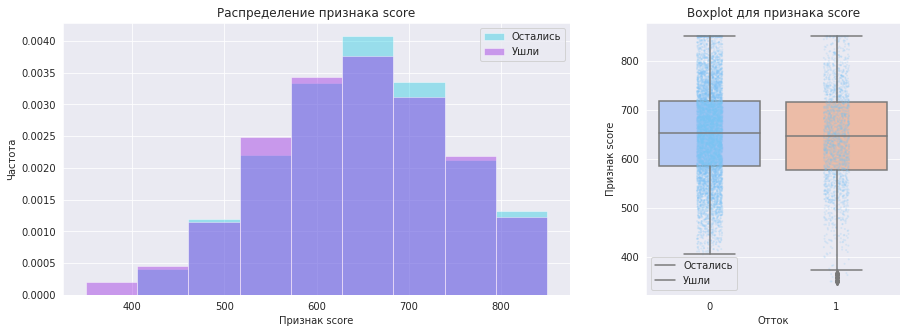

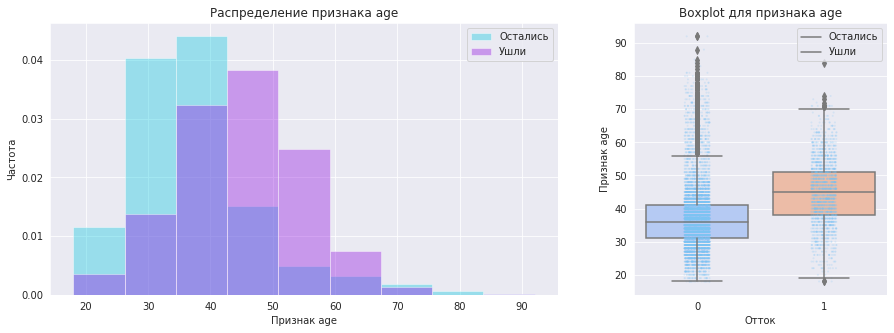

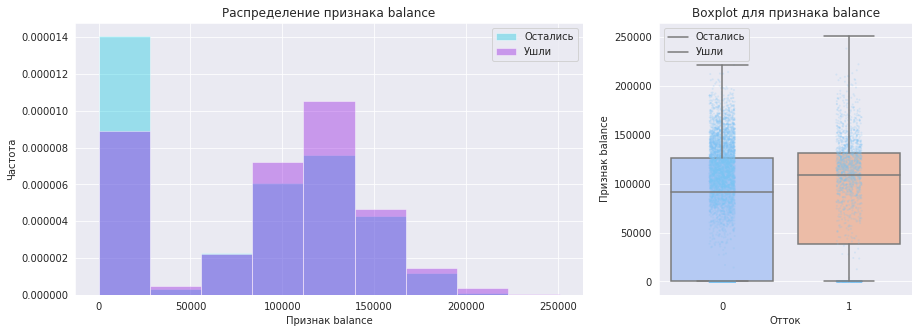

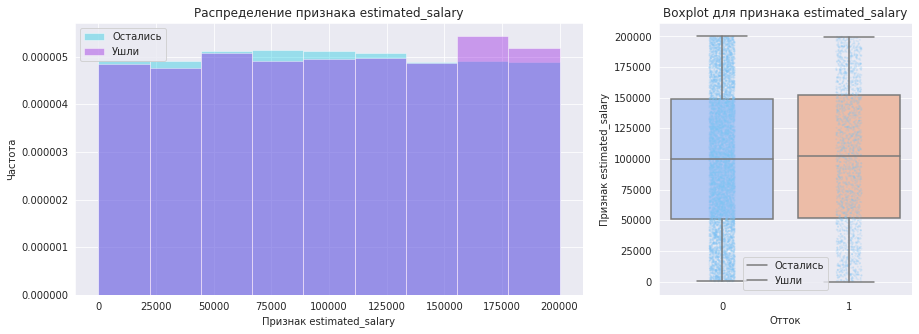

In [39]:
for col in numeric:
    hist_boxplot_hue_churn(bank_data, col)

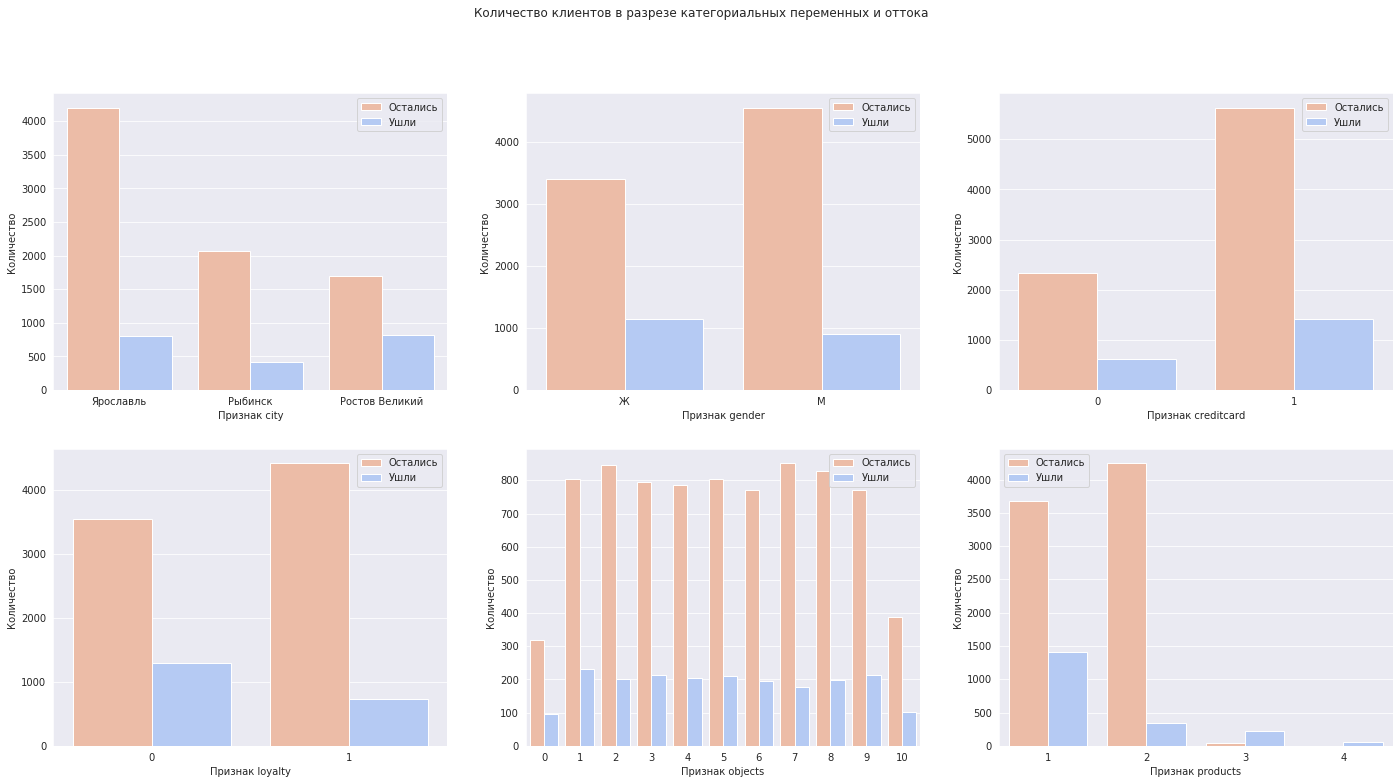

In [40]:
fig, ax = plt.subplots(2, int(len(categorical)/2), figsize=(24, 12))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(data=bank_data, x=variable, hue='churn', ax=subplot, palette="coolwarm_r")
    subplot.set_ylabel('Количество')
    subplot.set_xlabel('Признак {}'.format(variable))
    subplot.legend(labels=['Остались', 'Ушли'])
fig.suptitle("Количество клиентов в разрезе категориальных переменных и оттока");

Судя по графикам, можно определить параметры, которые свидетельствуют о возможном уходе клиента в отток. Это:

1. баланс на счете ниже среднего;
2. низкая активность;
3. возраст выше среднего.

Также следует обращить внимание на пол и число продуктов:

1. женщины более склонны к оттоку;
2. в отток больше уходят клиенты с 1 продуктом, чем те, у кого 2 продукта.

### Изучение признаков в разрезе количества продуктов

In [41]:
display(bank_data_corr.groupby('products')['score'].agg('count'))

products
1    5084
2    4590
3     266
4      60
Name: score, dtype: int64

Видим, что в выборке у нас очень мало клиентов с 3 и 4 продуктами (266 и 60 соотвественно). Подавляющее большиство клиентов пользуются 1-2 продуктами банка.

Изучим средние значения признаков для клиентов с разным числом продуктов.

In [42]:
display(bank_data_corr.groupby('products').agg('mean'))

,score,age,objects,balance,creditcard,loyalty,estimated_salary,churn,balance_na,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
products,,,,,,,,,,,,,,
1,649.120968,39.673092,4.974626,98551.870614,0.703777,0.504131,99487.256851,0.277144,0.178009,0.451613,0.548387,0.265342,0.240165,0.494493
2,652.188671,37.753595,5.051852,51879.145813,0.707190,0.532898,100452.012821,0.075817,0.566449,0.448802,0.551198,0.226580,0.257734,0.515686
3,648.105263,43.195489,5.003759,75458.328195,0.714286,0.424812,104318.130564,0.827068,0.368421,0.560150,0.439850,0.360902,0.248120,0.390977
4,653.583333,45.683333,5.300000,93733.135000,0.683333,0.483333,104763.723333,1.000000,0.233333,0.633333,0.366667,0.400000,0.116667,0.483333


Выводы:

* Лучший показатель скоринга у клиентов с 2 и 4 продуктами (652-653)
* Клиенты с 3-4 продуктами старше (43-45), чем клиенты с 1-2 продуктами (38-40)
* У половины клиентов с 2 продуктами не указан баланс, вероятно, они пользуются продуктами банка без дебетового счета.
* Клиенты с 1-2 продуктами более лояльны (50-53%), чем клиенты с 3-4 продуктами(42-48%). Это отличная возможность для того, чтобы заинтересовать их еще какими-либо услугами банка.
* Клиенты с 1-2 продуктами предположительно зарабатывают меньше (99-100 т.р.), чем клиенты с 3-4 продуктами(104-105 т.р.).
* Отток с клиентами, у которых 3-4 продукта, довольно большой (80-100%), но так как их немного в выборке(порядка 320 человек), то на общий отток он оказывает не такое сильное влияние. В любом случае на это стоит обратить внимание при разработке программы по удержанию.
* Клиенты с 1 и 2 продуктами преимущественно из Ярославля (50-52%), 22-26% из Ростова и 24-26% из Рыбинска.
* Клиенты с 3 продуктами в основном из Ярославля (39%) и Ростова (36%), из Рыбинска таких клиентов 25%.
* Клиенты с 4 продуктами также в основном из Ярославля (48%) и Ростова (40%), из Рыбинска таких клиентов 12%.

Построим визуализацию в виде графиков распределения.

In [43]:
def hist_boxplot_hue_product(data, column):
    '''
    Функция строит гистограмму и боксплот для визуализации распределения с разбивкой по продуктам.
    ***
    На вход подается название датафрейма и столбца.
    '''
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [2, 1]})
    
    min_value = min(data[column])
    max_value = max(data[column])
    bins_range = np.linspace(min_value, max_value, 10) # список границ столбиков гистограмм

    sns.distplot(data.query('0 < products < 3')[column], kde=False, ax=ax1, color="#1ECBE1", norm_hist=True, bins = bins_range)
    sns.distplot(data.query('2 < products < 5')[column], kde=False, ax=ax1, color="#961EE1", norm_hist=True, bins = bins_range)
    ax1.set_ylabel('Частота')
    ax1.set_xlabel('Признак {}'.format(column))
    ax1.set_title("Распределение признака {}".format(column))
    ax1.legend(labels=['1-2 продукта', '3-4 продукта'])
    
    sns.boxplot(y=column, x='products', data=data, ax=ax2, palette="coolwarm")
    sns.stripplot(y=column, x='products', data=data, jitter=True, zorder=1, color='#7cc3f2', ax=ax2, size=2,alpha=0.2)

    ax2.set_title("Boxplot для признака {}".format(column))
    ax2.set_xlabel('Число продуктов')
    ax2.set_ylabel('Признак {}'.format(column))
    
    plt.show()

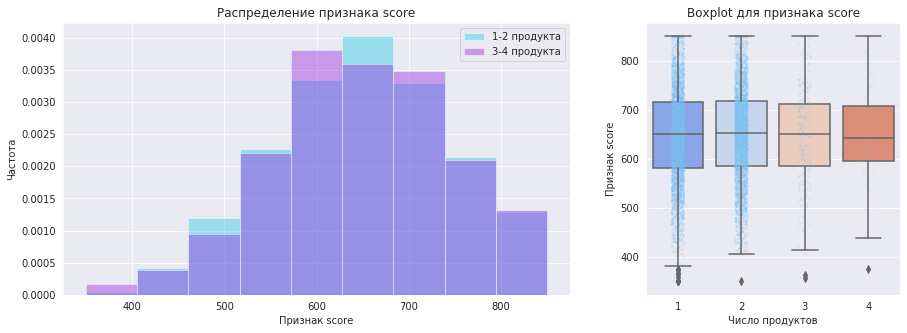

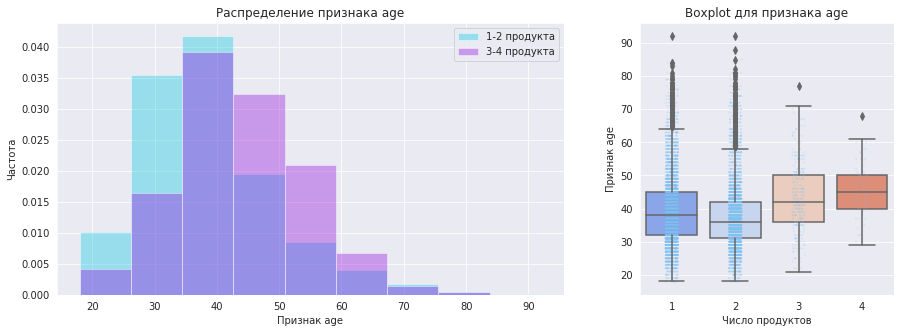

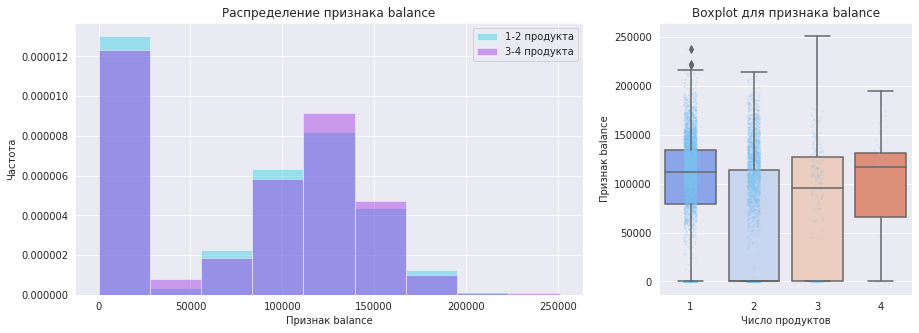

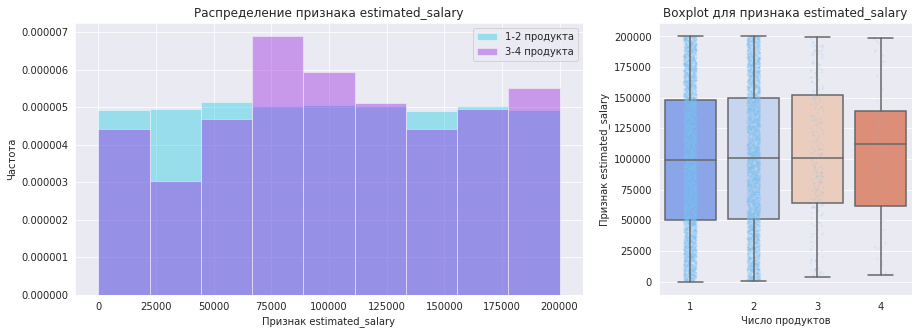

In [44]:
for col in numeric:
    hist_boxplot_hue_product(bank_data, col)

1. Видим, что баллы скоринга для всех групп примерно на одном уровне (648-654).
2. Клиенты с 1-2 продуктами моложе, чем клиенты с 3-4 продуктами.
3. Много незаполненных данных о балансе у клиентов с 2-3 продуктами (вероятно, для этих продуктов не нужно наличие дебетового счета)
4. Предполагаемая зарплата у клиентов с 3-4 продуктами несколько выше (104-105 т.р.), чем у клиентов с 1-2 продуктом(~ 100 т.р.).


Посмотрим на категориальные признаки.

In [45]:
#определим категориальные признаки
categorical_for_products = ['city', 'gender', 'creditcard', 'loyalty', 'objects', 'churn']

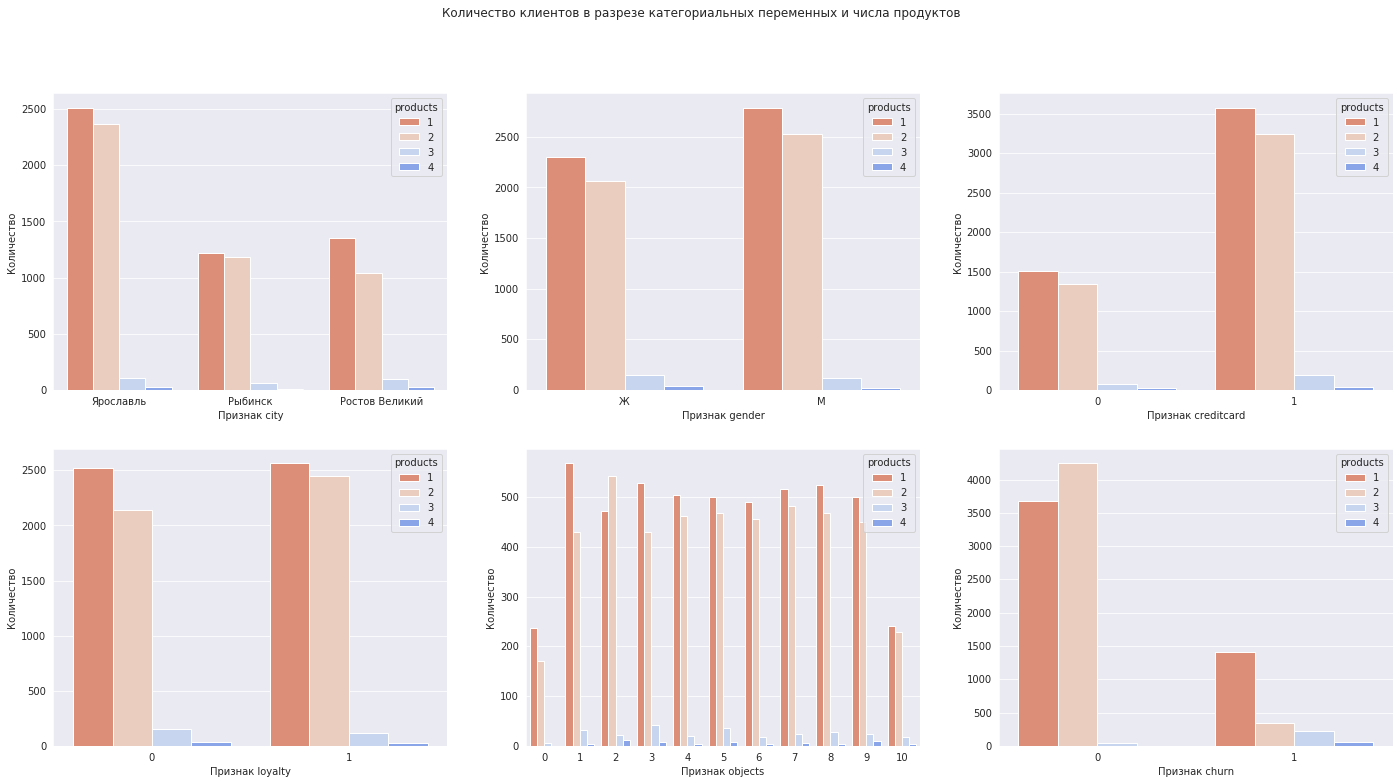

In [46]:
fig, ax = plt.subplots(2, int(len(categorical)/2), figsize=(24, 12))
for variable, subplot in zip(categorical_for_products, ax.flatten()):
    sns.countplot(data=bank_data, x=variable, hue='products', ax=subplot, palette="coolwarm_r")
    subplot.set_ylabel('Количество')
    subplot.set_xlabel('Признак {}'.format(variable))
fig.suptitle("Количество клиентов в разрезе категориальных переменных и числа продуктов");

В целом видим, что клиентов с 3-4 продуктами действительно мало. Большинство клиентов из Ярославля (в нем клиентов с 1 продуктов незначительно больше, чем клиентов с 2 продуктами). Среди женщин и мужчин больше тех, у кого 1 продукт (но также незначительно, на 5-10%). Средаи активных клиентов примерно равное число тех, у кого 1 и 2 продукта.
1 объект недвижимоски чаще замечен у пользователей 1 продукта, владельцами 2 объектов вляются в большей мере те, у кого 2 продукта. Оттук выше у тех, кто пользуется 1 продуктом, и меньше у тех , кто пользуется 2 продуктами банка.


## Шаг 3. Кластеризация клиентов

Алгоритм кластеризации может помочь выделить сегменты клиентов и предложить каждому сегменту подходящий вариант продукта и коммуникацию. 

In [47]:
#подготовим данные для кластеризации, удалим 2 столбца с названиями городов и полом
bank_data_cluster = bank_data_corr.drop(columns=['city_orig', 'gender_orig'])

Для выделения количества кластеров воспользуемся иерархической агломеративной кластеризацией. 

Выполним стандартизацию и передадим получившуюся стандартизированную таблицу в качестве параметра функции linkage(). Чтобы диаграмма получилась показательной, передадим параметру method значение 'ward'.

In [48]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(bank_data_cluster)

linked = linkage(X_sc, method = 'ward') 

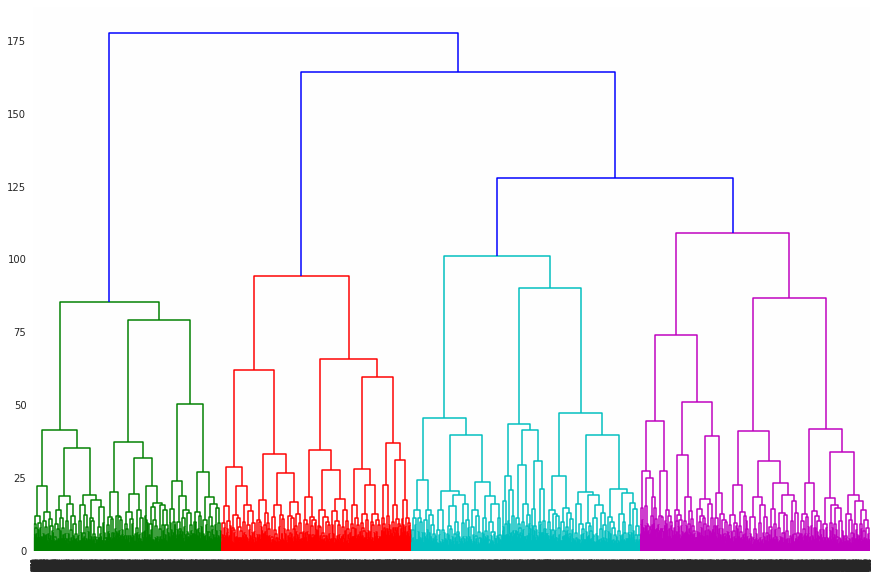

In [49]:
#визуализируем
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

На основании полученного графика можно выделить 4 кластера. После оценки оптимального числа кластеров можно запустить более быстрый алгоритм K-Means.

In [50]:
# задаём модель k_means с числом кластеров 4
km = KMeans(n_clusters = 4, random_state=0
           )
# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
bank_data_cluster['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
bank_data_cluster.groupby('cluster_km').agg('mean')

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_na,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
cluster_km,,,,,,,,,,,,,,,
0,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432,0.000000,0.475488,0.524512,1.0,0.0,0.0
1,651.333872,38.890997,5.032297,61818.147763,1.539362,0.694792,0.529673,99440.572281,0.166734,0.484053,0.439645,0.560355,0.0,1.0,0.0
2,648.306139,38.437165,5.063865,186.956625,1.786980,0.719407,0.520808,99214.903704,0.142563,0.996292,0.459827,0.540173,0.0,0.0,1.0
3,650.946270,38.581755,4.948976,120169.592486,1.290684,0.694627,0.512949,100541.136958,0.179358,0.000000,0.442598,0.557402,0.0,0.0,1.0


Визуализируем распределения категориальных признаков для каждого кластера.

In [51]:
categorical = ['creditcard', 'loyalty', 'objects', 'products', 'churn', 'balance_na', 'gender_Ж', 'gender_М']

Кластер 0


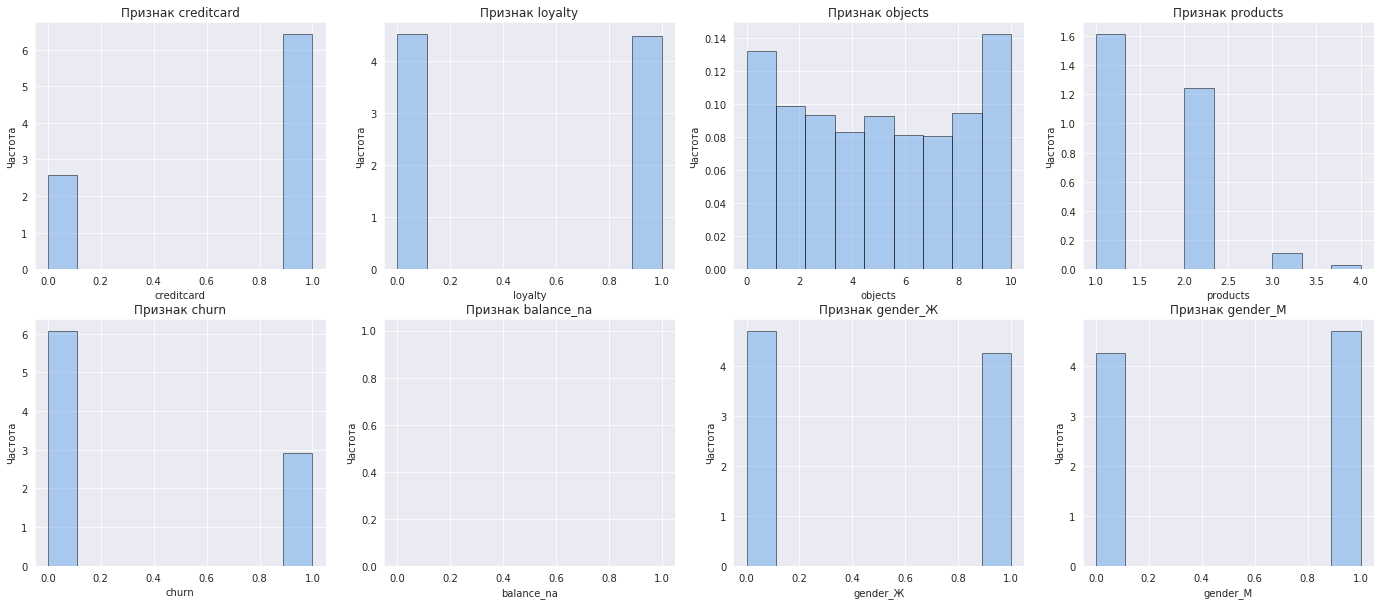

Кластер 1


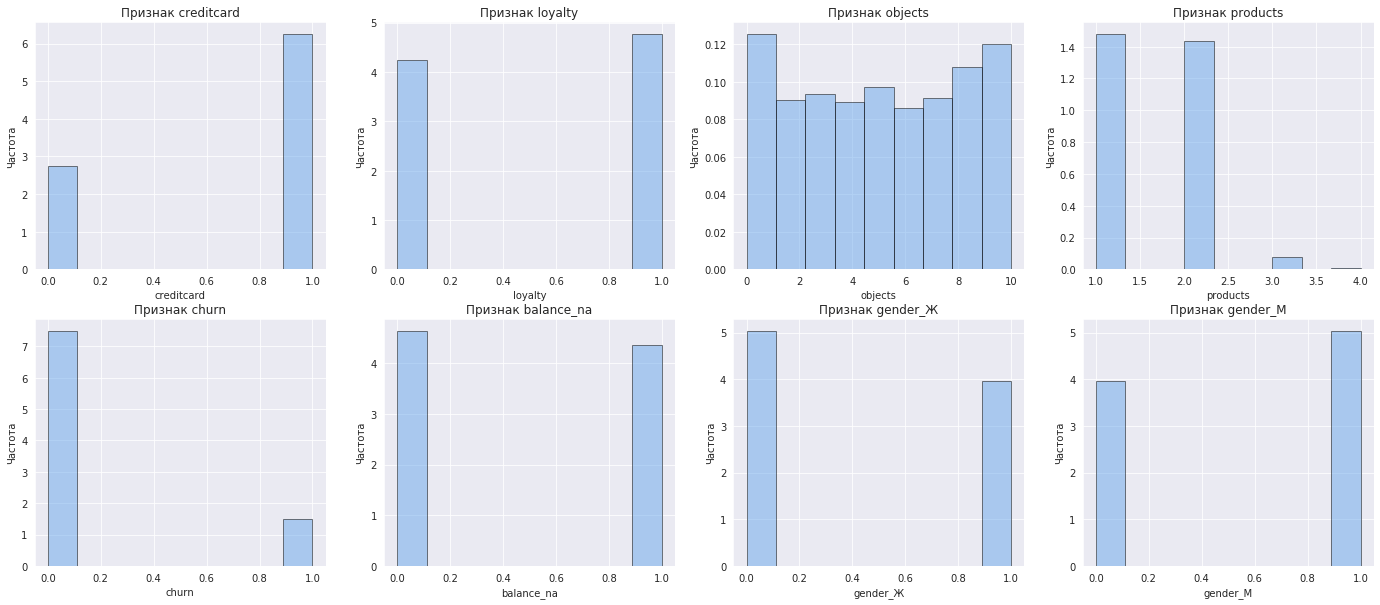

Кластер 2


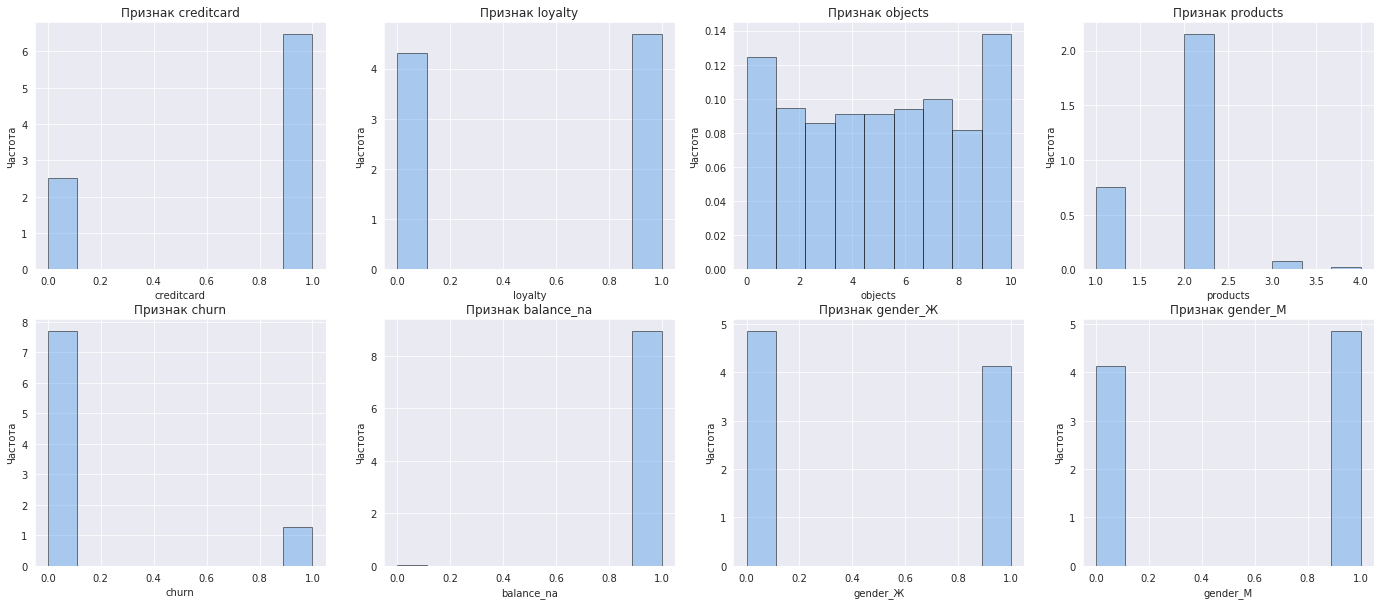

Кластер 3


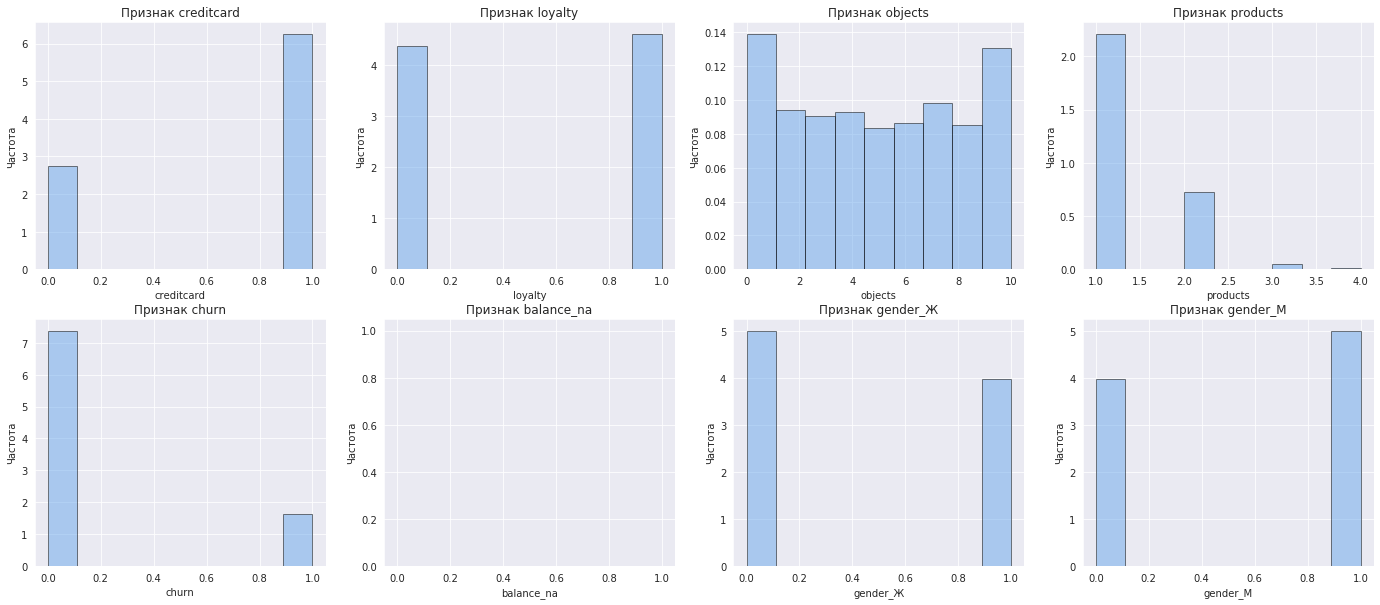

In [52]:
for j in sorted(bank_data_cluster['cluster_km'].unique()):
    print("Кластер {}".format(j))
    fig, ax = plt.subplots(2, 4, figsize=(24, 10))
    df_cluster = bank_data_cluster[bank_data_cluster['cluster_km'] == j]
    r=0
    k=0
    for column in categorical:
        min_value = min(df_cluster[column])
        max_value = max(df_cluster[column])
        bins_range = np.linspace(min_value, max_value, 10) # список границ столбиков гистограмм
#       sns.distplot(df_cluster[column], kde=False, color="b", norm_hist=True, bins = bins_range)
        ax[r,k].hist(df_cluster[column],
                        bins=bins_range, 
                        alpha=0.5, 
                        ec='black',
                        color="#69A7EB",
                        normed=True
                        )
        ax[r,k].set_ylabel('Частота')
        ax[r,k].set_xlabel(str(column))
        ax[r,k].set_title('Признак '+ str(column))
        if k == 3:
            k = 0
            r = r+1
        else:
            k = k+1
    plt.show()

Визуализируем распределения числовых признаков для каждого кластера.

Кластер 0


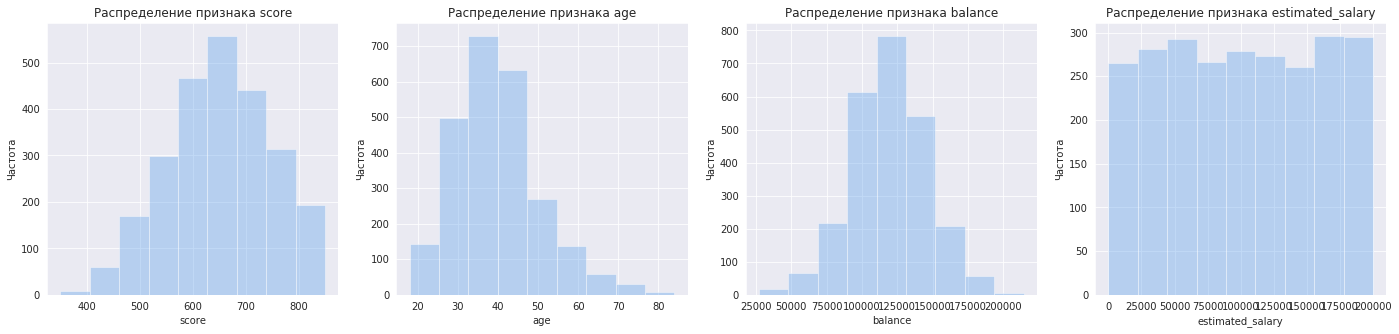

Кластер 1


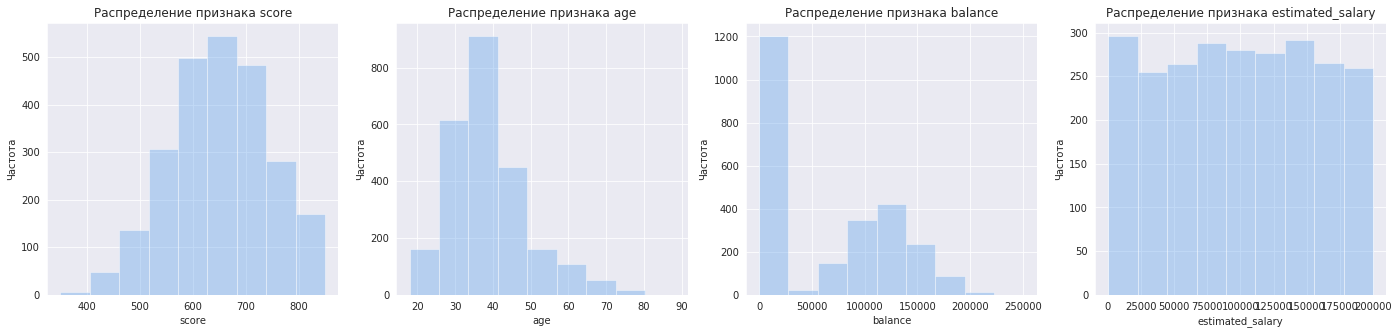

Кластер 2


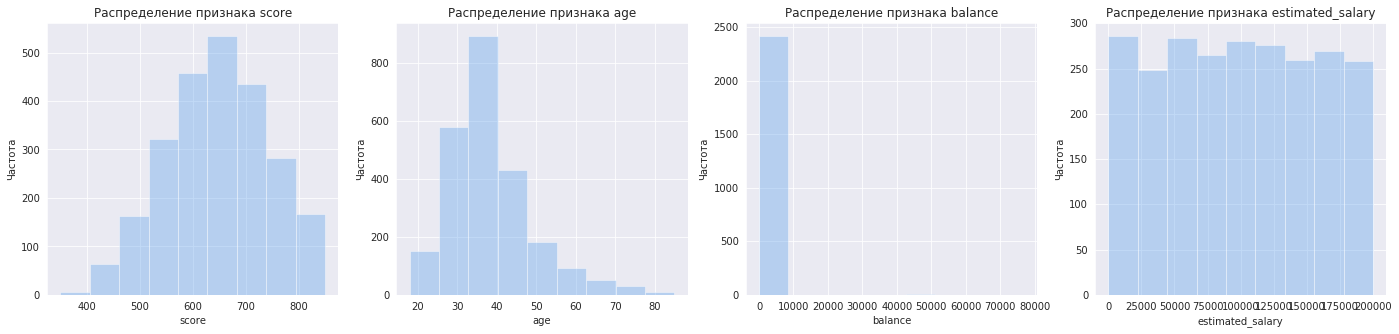

Кластер 3


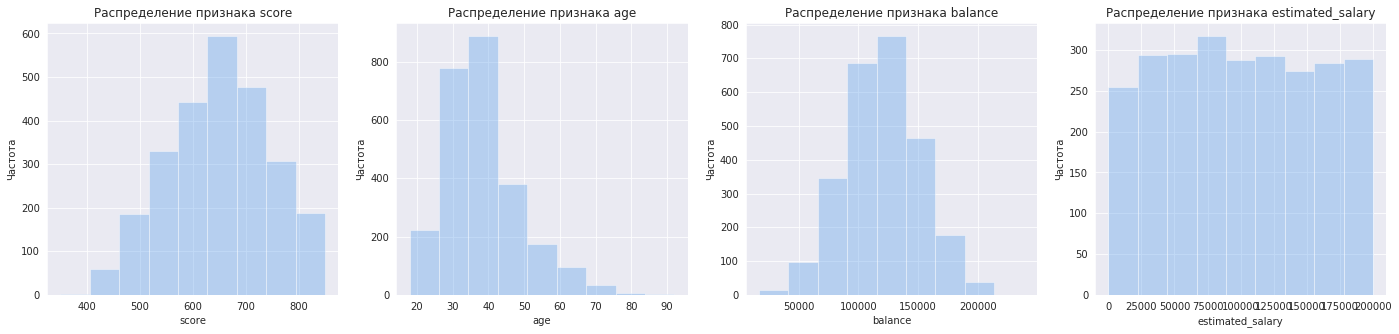

In [53]:
numeric = ['score', 'age', 'balance', 'estimated_salary']

sns.set_style("darkgrid")
    
for j in sorted(bank_data_cluster['cluster_km'].unique()):
    print("Кластер {}".format(j))
    fig, ax = plt.subplots(1, 4, figsize=(24, 5))
    df_cluster = bank_data_cluster[bank_data_cluster['cluster_km'] == j]
    k=0
    for column in numeric:
        min_value = min(df_cluster[column])
        max_value = max(df_cluster[column])
        bins_range = np.linspace(min_value, max_value, 10) # список границ столбиков гистограмм
        sns.distplot(df_cluster[column], kde=False, ax=ax[k], color="#69A7EB", bins = bins_range)
        ax[k].set_ylabel('Частота')
        ax[k].set_xlabel(str(column))
        ax[k].set_title('Распределение признака '+ str(column))
        k = k+1
    plt.show()

На основании разделения на кластеры и полученных графиков можно сделать следующее резюме по клиентам:

1. В 0 кластере собраны клиенты из Ростова Великого, по полу распределены примерно одинаково (53% мужчин и 48% женщин). Средний баланс на счете - 120 т.р. Процент оттока у этого кластера самый большой - 32%. Предполагаемая средняя зарплата у таких клиентов - 101 т.р. 49% таких клиентов - лояльные пользователи. В среднем у них 1-2 продукта и 5 объектов во владении, довольно большое число клиентов владеет 10 объектами, но при этом у какой-то части вообще нет объектов в собственности, поэтому среднее установилось в районе 5. Среднее число баллов скоринга - 651.


2. В 1 кластере собраны клиенты из Рыбинска. По полу распределены примерно одинаково (56% мужчин и 44% женщин). Средний баланс на счете в 2 раза меньше, чем в кластерах 2 и 3 - 62 т.р, возможно, это произошло  из-за того, что у половины из выборки баланс не указан вовсе. Процент оттока у этого кластера небольшой - 16%. Предполагаемая средняя зарплата у таких клиентов - 99 т.р. 53% таких клиентов - лояльные пользователи. В среднем у них 1-2 продукта и 5 объектов во владении. Среднее число баллов скоринга - 651.


3. Во 2 кластере собраны клиенты из Ярославля, у которых в 99% случаев не заполнено поле с балансом. Предполагается, что это клиенты, которые используют продукт банка, не предполагающий заведение дебетового счета, например, ипотечный продукт. По полу распределены примерно одинаково (55% мужчин и 45% женщин). Процент оттока у этого кластера самый маленький - 14%. Предполагаемая средняя зарплата у таких клиентов - 99 т.р. 52% таких клиентов - лояльные пользователи. В среднем у них 2 продукта и 5 объектов во владении. Среднее число баллов скоринга - 648.


4. В 3 кластере собраны клиенты из Ярославля, по полу распределены примерно одинаково (55% мужчин и 45% женщин). Средний баланс на счете - 120 т.р, практически у всех это поле заполнено. Процент оттока у этого кластера небольшой - 18%. Предполагаемая средняя зарплата у таких клиентов - 100 т.р. 51% таких клиентов - лояльные пользователи. В среднем у них 1 продукт и 5 объектов во владении. Среднее число баллов скоринга - 651.

## Шаг 4. Проверка гипотез

### Гипотеза различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним

Проверим гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.

Начнем с формулировки нулевой гипотезы H0, которая всегда формулируется так, чтобы использовать знак равенства:

* Доходы клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, равны

Исходя из Н0 формулируется альтернативная гипотеза Н1:

* Доходы клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, различаются

Пороговое значение alpha примем за 5%.

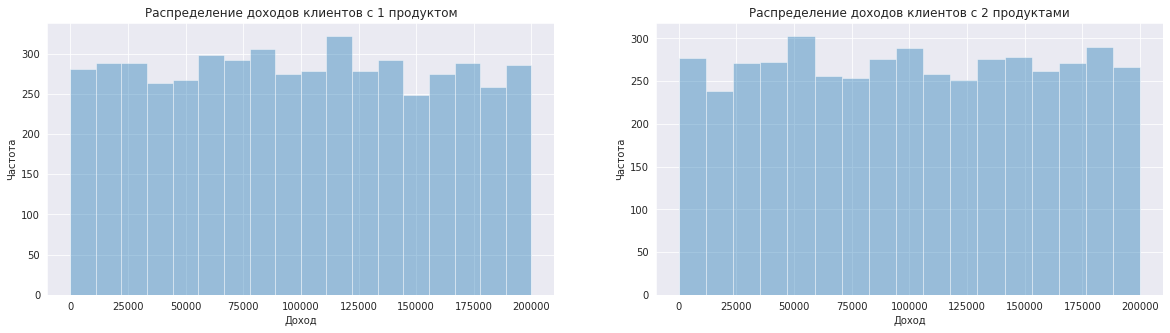

In [54]:
#проверим распределения
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))

sns.distplot(bank_data.query('products == 1')['estimated_salary'], kde=False, ax=ax1)
ax1.set_title("Распределение доходов клиентов c 1 продуктом")
ax1.set_ylabel('Частота')
ax1.set_xlabel('Доход')

sns.distplot(bank_data.query('products == 2')['estimated_salary'], kde=False, ax=ax2)
ax2.set_title("Распределение доходов клиентов с 2 продуктами")
ax2.set_ylabel('Частота')
ax2.set_xlabel('Доход')

plt.show()

Применим метод Манна—Уитни для оценки различий между двумя независимыми выборками и проверки "нормальности распределения". Преимущество его состоит в том, что мы отказываемся от предположения нормальности распределения и одинаковых дисперсий. То есть, этот метод можно использовать как при нормальном распределении, так и при распределении, отличном от нормального. В данном случае у нас равномерное распределение.

In [55]:
alpha = 0.05

results = st.mannwhitneyu(
    bank_data.query('products == 1')['estimated_salary'], 
    bank_data.query('products == 2')['estimated_salary'], 
    alternative = 'two-sided')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4079566651927651
Не получилось отвергнуть нулевую гипотезу


Не удалось отвергнуть нулевую гипотезу: доходы клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, не различаются.

### Гипотеза различия оттока между теми клиентами, которые пользуются двумя и более продуктами банка, и теми, которые пользуются одним

Проверим гипотезу различия факта оттока между теми клиентами, которые пользуются двумя и более продуктами банка, и теми, которые пользуются одним.

Сформулируем нулевую гипотезу H0, которая всегда формулируется так, чтобы использовать знак равенства:

* Отток клиентов, которые пользуются двумя и более продуктами банка, и отток тех, которые пользуются одним, равны

Исходя из Н0 формулируется альтернативная гипотеза Н1:

* Отток клиентов, которые пользуются двумя и более продуктами банка, и отток тех, которые пользуются одним, различаются

Пороговое значение alpha примем за 5%.

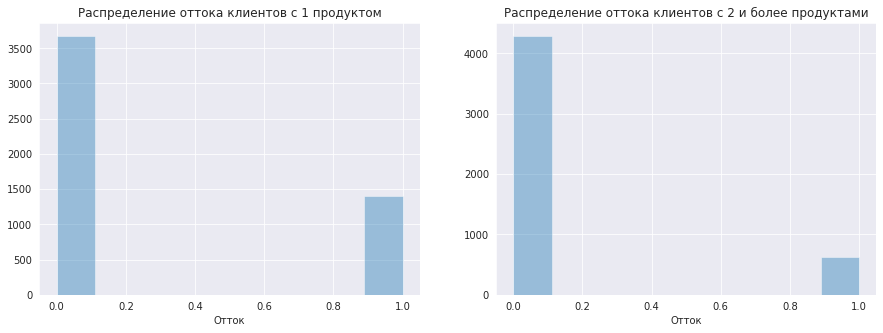

In [61]:
#проверим распределения
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

bins_range = np.linspace(0, 1, 10) # список границ столбиков гистограмм
    
sns.distplot(bank_data.query('products == 1')['churn'], kde=False, ax=ax1, bins = bins_range)
ax1.set_title("Распределение оттока клиентов c 1 продуктом")
#ax1.set_ylabel('Частота')
ax1.set(ylabel=None)
ax1.set_xlabel('Отток')

sns.distplot(bank_data.query('products > 1')['churn'], kde=False, ax=ax2, bins = bins_range)
ax2.set_title("Распределение оттока клиентов с 2 и более продуктами")
#ax2.set_ylabel('Частота')
ax2.set(ylabel=None)
ax2.set_xlabel('Отток')

plt.show()

Визуально заметно, что отток у клиентов с 2 и более продуктами больше, чем у клиентов с 1 продуктом. Проверим эту гипотезу.

Данные не похожи на нормальное распределение, у нас всего 2 значения, поэтому нам нужен непараметрический критерий.
Так как churn - величина бинарная, будет оптимальным использование Z-критерия для сравнения долей.

In [57]:
alpha = 0.05

from statsmodels.stats import weightstats as stests

results, pvalue = stests.ztest(
    bank_data.query('products == 1')['churn'], 
    x2=bank_data.query('products > 1')['churn'],
    value = 0,
    alternative='two-sided')

print('p-значение:', float(pvalue))

if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.0079099625883425e-79
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу: отток клиентов, которые пользуются двумя и более продуктами банка, и отток тех, которые пользуются одним, различаются.

## Шаг 5. Выводы и базовые рекомендации по работе с клиентами

В проекте был проведен анализ данных о клиентах банка «Метанпромбанк».

Сформированы группы клиентов: 

**1 группа** - клиенты с довольно большим оттоком (32%), живут в Ростове Великом, средний баланс на счете у них - 120 т.р, предполагаемая средняя зарплата - 101 т.р. В среднем у них 1-2 продукта и 5 объектов во владении, довольно большое число клиентов владеет 10 объектами, но при этом у какой-то части вообще нет объектов в собственности, поэтому отток следует поисследовать как для клиентов с 10 объектами, так и для клиентов, у которых нет объектов недвижимости (возможно, заинтересовать их воспользоваться ипотечными программами банка).

**2 группа** - клиенты с небольшим оттоком (16%), живут в Рыбинске, средний баланс на счете в 2 раза меньше по сравнению с другими группами - 62 т.р. Вероятно, по причине того, что у половины из выборки баланс не указан вовсе. Возможно, они используют продукты банка, не предполагающие наличие дебетового счета, например, кредитный или ипотечный продукт.  В среднем у клиентов 1-2 продукта и 5 объектов во владении. Предполагаемая средняя зарплата - 99 т.р.

**3 группа** - Клиенты с небольшим оттоком (14-18%), живут в Ярославле, в 99% случаев у них не заполнено поле с балансом. Вероятно, это клиенты, которые используют продукт банка, не предполагающий заведение дебетового счета, например, ипотечный продукт. В случае ипотечного продукта клиенты остаются с банком на довольно продолжительный срок, поэтому у банка есть отличная возможность заслужить лояльность таких клиентов, а также предложить им продукты, предполагающие наличие дебетового счета (вклады, дебетовые карты, зарплатные проекты и т.д.)
В среднем у таких клиентов 2 продукта и 5 объектов во владении. 

Отток у тех клиентов, у кого не указан баланс, ниже, чем у клиентов с дебетовым балансом. 
Отсутвие информации о балансе в рамках данного проекта понимается как отсутствие дебетовых продуктов, значит это является характеристикой лояльного клиента. То есть, если у клиента имеется кредит, ипотека или какие-либо брокерские услуги, то он меньше склонен к оттоку.

**Выводы и рекомендации:**

1. Если у клиента не указан баланс, и он является потребителем услуги, не предполагающей наличие дебетового счета, то он менее склонен к оттоку. Если у них долгосрочный банковский продукт, такие клиенты остаются с банком на довольно продолжительный срок, поэтому у банка есть отличная возможность заслужить лояльность таких клиентов, а также предложить им продукты, предполагающие наличие дебетового счета (вклады, дебетовые карты, зарплатные проекты и т.д.).
2. В Ростове Великом довольно большой отток клиентов, стоит направить внимание на удержание.
3. В Ростове Великом довольно большое число клиентов владеет 10 объектами, но при этом у какой-то части вообще нет объектов в собственности, поэтому отток следует поисследовать как для клиентов с 10 объектами (возможно, предложить им какие-либо премиальные индивидуальные условия), так и для клиентов, у которых нет объектов недвижимости (возможно, заинтересовать их воспользоваться ипотечными программами банка).
4. Клиентам из Рыбинска также можно порекомендовать продукты, предполагающие наличие дебетового счета. Удержание старого клиента значительно дешевле (по трудозатратам и стоимости), чем поиск и привлечение нового клиента, тем более нужного этому банку.
5. В целом, подавляющее большинство клиентов - это владельцы 1-2 продуктов (в Ярославле много клиентов, у кого 2 продукта, в Рыбинске и Ростове большинство с 1 продуктом), поэтому следует направить внимание на увеличение числа продуктов для уже имеющихся клиентов, так как они по большей части лояльны к банку и более охотно воспользуются дополнительными продуктами, чем те, кто еще не является клиентом банка. Наибольший доход банку приносят именно такие клиенты, поскольку они пользуются большим количеством продуктов.
6. Судя по предоставленным данным, клиентами банка являются люди возраста 37-45 лет. Стоит направить внимание на привлечение клиентов других возрастных сегментов, например, молодых людей (возраст 25-35) со стабильным доходом.
7. Отток с клиентами, у которых 3-4 продукта (они в основном из Ярославля и Ростова), довольно большой (80-100%), но так как их немного в выборке (порядка 320 человек), то на общий отток он оказывает не такое сильное влияние. В любом случае на таких клиентов стоит обратить внимание при разработке программы по удержанию.

**Примеры реализации принципов взаимодействия с клиентами и их удержания в виде маркетинговых действий:**

1. Взаимодействие в приложении банка и социальных медиа: регулярная разработка и обновление приложения, рекомендательный и полезный контент для клиентов. Выстраивание "личной" связи с брендом.
2. Персонализация контента (предлагать продукты только тем, кому они действительно интересны). Умеренное и подходящее СМС-информирование. 
3. Грамотная поддержка клиентов (быстрая обработка запросов) и регулярное отслеживание удовлетворенности (eNPS, CES, HEART).
4. Омниканальная модель для взаимодействия с клиентами (получение одного и того же уровня сервиса и набора услуг вне зависимости от выбранного канала связи с банком).